In [4]:
# PyTorchLightning is a light weight pytorch wrapper that
# helps users organize their pytorch code and streamline the
# training process. It eliminates the boilerplate code,
# simplifies the training loop, and provides more structured
# approach to pytorch programming without compromising flexibility.

In [2]:
!pip3 install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [lightning]  9/10 [lightning]ghtning]


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import lightning.pytorch as pl

from torch.utils.data import TensorDataset, DataLoader

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder

In [18]:
# apart from abstracting away the training process of a nn
# (training loop, etc), lightning provides lightning data module.
# LightningDataModule abstract and organize data-related aspects
# of our deep learning model. It's a way to decouple the data
# processing steps, the loading, preprocessing and splitting data
# from the model training logic.

class InsuranceDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 8):
        super().__init__()
        self.batch_size = batch_size

    def prepare_data(self):
        self.insurance_data = pd.read_csv("insurance.csv")
        
    def setup(self, stage = None):
        # splitting up the data, transformations, pre-processing
        # are done here.
        # this will be called on every cpu/ gpu device separately
        # stage - what stage the model is currently running
        #         either fit - training, or validation or test

        X = self.insurance_data.drop(columns = ["charges"])
        Y = self.insurance_data["charges"]

        if stage == "fit" or stage is None:
            X_train, X_val, Y_train, Y_val = \
            train_test_split(X, Y, test_size = 0.2, random_state = 123)

            categorical_features = ["sex", "smoker", "region"]

            categorical_transformer = OneHotEncoder(
                handle_unknown = "ignore", drop = "first", sparse_output = False
            )

            preprocessor = ColumnTransformer(
                transformers = [("cat_tr", categorical_transformer, categorical_features)],
                remainder = "passthrough"
            )

            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)

            Y_train = Y_train.to_numpy()
            Y_val = Y_val.to_numpy()

            ## standarize scaling features
            stdscaler = StandardScaler()
            X_train = stdscaler.fit_transform(X_train)
            X_val = stdscaler.transform(X_val)

            ## Min max scaling targets
            min_max_scaler = MinMaxScaler()
            Y_train = min_max_scaler.fit_transform(Y_train.reshape(-1, 1))
            Y_val = min_max_scaler.transform(Y_val.reshape(-1, 1))

            # convert to tensors
            self.train_inputs = torch.from_numpy(X_train).float()
            self.train_targets = torch.from_numpy(Y_train.reshape(-1,1)).float()
            self.val_inputs = torch.from_numpy(X_val).float()
            self.val_targets = torch.from_numpy(Y_val.reshape(-1,1)).float()
        
    def train_dataloader(self):
        train_dataset = TensorDataset(
            self.train_inputs, self.train_targets
        )
        # num_workers for the num of cores in the device
        train_loader = DataLoader(
            dataset = train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 4
        )
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(
            self.val_inputs, self.val_targets
        )
        validation_loader = DataLoader(
            dataset = validation_dataset,
            batch_size = self.batch_size,
            #shuffle = False,
            num_workers = 4
        )
        return validation_loader
        

In [19]:
# create an instance of data module
insurance_dm = InsuranceDataModule()
# prepare the data and setup
insurance_dm.prepare_data()
insurance_dm.setup()

# get the data loader
train_dl = insurance_dm.train_dataloader()

next(iter(train_dl))

[tensor([[ 0.9888,  2.0000, -0.5809,  1.6095, -0.5478, -1.0720,  1.5795, -0.8865],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478, -1.4973,  0.5741, -0.8865],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478, -0.0797, -0.2851, -0.0674],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478, -0.2923, -2.1246, -0.0674],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478, -1.1429,  1.8719, -0.8865],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  1.3380,  1.3967, -0.8865],
         [-1.0113, -0.5000, -0.5809, -0.6213, -0.5478, -1.2138, -1.2406, -0.8865],
         [-1.0113,  2.0000, -0.5809, -0.6213, -0.5478,  0.0621, -0.4197, -0.0674]]),
 tensor([[6.0198e-01],
         [2.4625e-04],
         [7.8940e-02],
         [6.4984e-02],
         [1.1638e-02],
         [1.7463e-01],
         [2.6192e-02],
         [3.4504e-01]])]

In [20]:
# val data loader
val_dl = insurance_dm.val_dataloader()
next(iter(val_dl))

[tensor([[-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7000,  1.9999,  0.7517],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.5050,  1.1117, -0.0674],
         [-1.0113,  2.0000, -0.5809, -0.6213,  1.8254, -0.8594,  0.1254, -0.8865],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478, -0.2923, -1.0827, -0.0674],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478,  1.4797, -0.8152, -0.8865],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7709, -0.4130,  1.5709],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.8594, -1.9510,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254, -0.4341, -2.0183, -0.0674]]),
 tensor([[0.1412],
         [0.0577],
         [0.5485],
         [0.0651],
         [0.1793],
         [0.1559],
         [0.0603],
         [0.0593]])]

In [21]:
# Create the neural network model using Lightning

class LitRegressionModule(pl.LightningModule):
    def __init__(self, num_features, learning_rate = 0.01):
        super().__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_output = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
        # save parameters of this constructor, so that it can be
        # accessible in other member functions using hparams
        self.save_hyperparameters()

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr = self.hparams.learning_rate)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_output(x)

        return (x)

    def training_step(self, batch, batch_idx):
        # function to execute steps for every batch of data
        
        x, y = batch
        output = self.forward(x)

        loss_fn = nn.MSELoss(reduction = "mean")
        loss = loss_fn(output, y)

        self.log("train_loss", loss, prog_bar = True)

        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)

        loss_fn = nn.MSELoss(reduction = "mean")
        loss = loss_fn(output, y)

        self.log("val_loss", loss, on_epoch = True, prog_bar = True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch
        ## self(x) does forward???
        return self(x)
        

In [22]:
model = LitRegressionModule(num_features = 8)

print(model)

LitRegressionModule(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_output): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [23]:
# now run the training

from pytorch_lightning.loggers import CSVLogger

insurance_dm = InsuranceDataModule()

logger = CSVLogger("logs", name = "pytorch_lightning_training")

trainer = pl.Trainer(max_epochs = 50, logger = logger)

trainer.fit(model, datamodule = insurance_dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type   | Params | Mode 
------------------------------------------------
0 | layer_1      | Linear | 144    | train
1 | layer_2      | Linear | 544    | train
2 | layer_3      | Linear | 528    | train
3 | layer_output | Linear | 17     | train
4 | relu         | ReLU   | 0      | train
------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [24]:
predictions = trainer.predict(model = model, dataloaders = insurance_dm.val_dataloader())

predictions

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

[tensor([[0.1682],
         [0.1325],
         [0.4326],
         [0.0674],
         [0.2376],
         [0.1719],
         [0.0470],
         [0.0769]]),
 tensor([[0.0392],
         [0.1286],
         [0.1328],
         [0.1769],
         [0.1630],
         [0.4621],
         [0.2236],
         [0.5120]]),
 tensor([[0.2253],
         [0.0225],
         [0.5649],
         [0.7011],
         [0.4223],
         [0.8561],
         [0.0176],
         [0.1553]]),
 tensor([[ 0.0292],
         [ 0.1334],
         [ 0.2448],
         [ 0.0969],
         [ 0.2180],
         [-0.0210],
         [ 0.1044],
         [ 0.2381]]),
 tensor([[0.0698],
         [0.0619],
         [0.0661],
         [0.1446],
         [0.2935],
         [0.0211],
         [0.1134],
         [0.2450]]),
 tensor([[0.1223],
         [0.1132],
         [0.0681],
         [0.3559],
         [0.1719],
         [0.0116],
         [0.1951],
         [0.1779]]),
 tensor([[0.2288],
         [0.0481],
         [0.1855],
         [0

In [25]:
# stack the predictions
y_pred_stacked = torch.cat(predictions)

y_pred_stacked[:10]

tensor([[0.1682],
        [0.1325],
        [0.4326],
        [0.0674],
        [0.2376],
        [0.1719],
        [0.0470],
        [0.0769],
        [0.0392],
        [0.1286]])

In [27]:
# compute metrics for the model

labels = []

for data, label in insurance_dm.val_dataloader():
    labels.extend(label)

In [28]:
y_true = torch.stack(labels)
y_true[:10]

tensor([[0.1412],
        [0.0577],
        [0.5485],
        [0.0651],
        [0.1793],
        [0.1559],
        [0.0603],
        [0.0593],
        [0.0090],
        [0.1340]])

In [29]:
# predictions and labels are collected

# compute the MSE and R2Score

from torchmetrics.regression import R2Score
from torchmetrics.regression import MeanSquaredError

MSE = MeanSquaredError()
r2score = R2Score()

print("Mean Squared Error: ", round(MSE(y_pred_stacked, y_true).item(), 3))
print("R^2 Score: ", round(r2score(y_pred_stacked, y_true).item(), 3))

Mean Squared Error:  0.006
R2Score:  0.861


In [31]:
# lets check the metrics logged during the trainging process
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics.head(10)

,epoch,step,train_loss,val_loss
0,0,49,0.025017,NaN
1,0,99,0.012294,NaN
2,0,133,NaN,0.038764
3,1,149,0.012917,NaN
4,1,199,0.038222,NaN
5,1,249,0.026147,NaN
6,1,267,NaN,0.035863
7,2,299,0.027600,NaN
8,2,349,0.020026,NaN
9,2,399,0.028358,NaN


,train_loss,val_loss
epoch,,
0,0.025017,NaN
0,0.012294,NaN
0,NaN,0.038764
1,0.012917,NaN
1,0.038222,NaN
1,0.026147,NaN
1,NaN,0.035863
2,0.027600,NaN
2,0.020026,NaN


<Axes: xlabel='epoch'>

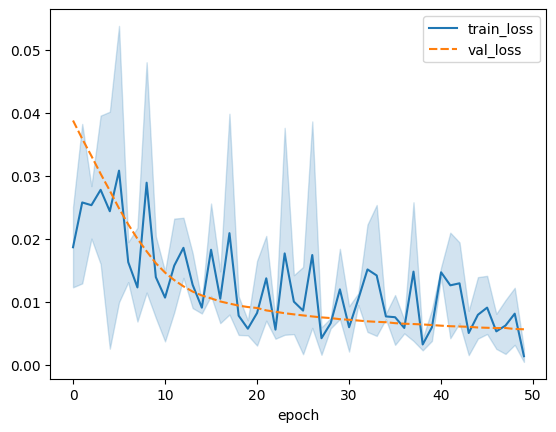

In [32]:
# drop the step column from the metrics
del metrics["step"]

# set the epoch column as index
metrics.set_index("epoch", inplace = True)

# display first few row of the metrics table, excluding any columns with NaN value
display(metrics.dropna(axis = 1, how = "all").head(10))

# create a line plot of the training metrics using seaborn
sns.lineplot(data = metrics)

        